In [4]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import folium

In [21]:
dataset = pd.read_csv("sf18_cleaned.csv")
dataset.head()

,Unnamed: 0,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,duration [s],Date_s,Weekday_s,Hour_s,Date_e,Weekday_e,Hour_e,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude
0,0,2018-01-31 22:52:36,2018-02-01 19:47:20,120,285,Mission Dolores Park,Webster St at O'Farrell St,2765,Subscriber,75284.0,2018-01-31,2,22,2018-02-01,3,19,37.761420,-122.426435,37.783521,-122.431158
1,1,2018-01-31 16:13:35,2018-02-01 15:57:18,15,15,San Francisco Ferry Building (Harry Bridges Pl...,San Francisco Ferry Building (Harry Bridges Pl...,2815,Customer,85423.0,2018-01-31,2,16,2018-02-01,3,15,37.795392,-122.394203,37.795392,-122.394203
2,2,2018-01-31 14:23:56,2018-02-01 10:16:53,304,296,Jackson St at 5th St,5th St at Virginia St,3039,Customer,71577.0,2018-01-31,2,14,2018-02-01,3,10,37.348759,-121.894798,37.325998,-121.877120
3,3,2018-01-31 14:53:24,2018-02-01 07:51:21,75,47,Market St at Franklin St,4th St at Harrison St,321,Customer,61077.0,2018-01-31,2,14,2018-02-01,3,7,37.773793,-122.421239,37.780955,-122.399749
4,4,2018-01-31 19:52:25,2018-02-01 06:58:32,74,19,Laguna St at Hayes St,Post St at Kearny St,617,Subscriber,39967.0,2018-01-31,2,19,2018-02-01,3,6,37.776435,-122.426244,37.788975,-122.403452


## delete all the trips without location and divide the trips into 12 months

### since their distance can´t be calculated

In [28]:
data = dataset[['start_station_name','end_station_name','start_station_latitude','start_station_longitude','end_station_latitude','end_station_longitude','start_time','duration [s]']]
data_cleaned = data.dropna(axis=0,how='any')
data_cleaned['month']=pd.DatetimeIndex(data_cleaned['start_time']).month
data_cleaned=data_cleaned.drop(['start_time'],axis=1)
data_cleaned

,start_station_name,end_station_name,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,duration [s],month
0,Mission Dolores Park,Webster St at O'Farrell St,37.761420,-122.426435,37.783521,-122.431158,75284.0,1
1,San Francisco Ferry Building (Harry Bridges Pl...,San Francisco Ferry Building (Harry Bridges Pl...,37.795392,-122.394203,37.795392,-122.394203,85423.0,1
2,Jackson St at 5th St,5th St at Virginia St,37.348759,-121.894798,37.325998,-121.877120,71577.0,1
3,Market St at Franklin St,4th St at Harrison St,37.773793,-122.421239,37.780955,-122.399749,61077.0,1
4,Laguna St at Hayes St,Post St at Kearny St,37.776435,-122.426244,37.788975,-122.403452,39967.0,1
...,...,...,...,...,...,...,...,...
1842139,Hubbell St at 16th St,Berry St at 4th St,37.766474,-122.398295,37.775880,-122.393170,474.0,12
1842140,Washington St at Kearny St,Market St at 10th St,37.795393,-122.404770,37.776619,-122.417385,841.0,12
1842141,Downtown Berkeley BART,Virginia St at Shattuck Ave,37.870348,-122.267764,37.876573,-122.269528,260.0,12
1842142,4th St at Mission Bay Blvd S,Esprit Park,37.770407,-122.391198,37.761634,-122.390648,293.0,12


## calculate the distance

In [29]:
#function that calculates the distance of a trip by the locations of start and end stations
import numpy as np

def haversine_vectorize(lon1, lat1, lon2, lat2):

    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    newlon = lon2 - lon1
    newlat = lat2 - lat1

    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2

    dist = 2 * np.arcsin(np.sqrt(haver_formula ))
    km = 6367 * dist #6367 for distance in KM for miles use 3958
    return km

In [30]:
data_cleaned['distance [km]']=haversine_vectorize(data_cleaned['start_station_longitude'],data_cleaned['start_station_latitude'],data_cleaned['end_station_longitude'],data_cleaned['end_station_latitude'])
data_cleaned=data_cleaned.drop(['start_station_latitude','start_station_longitude','end_station_latitude','end_station_longitude'],axis=1)
# drop trips when distance equals 0, cause they have the same start and end stations, impossible for us to analyse
data_cleaned.drop(data_cleaned[data_cleaned["distance [km]"]<=0].index, inplace = True)
data_cleaned

,start_station_name,end_station_name,duration [s],month,distance [km]
0,Mission Dolores Park,Webster St at O'Farrell St,75284.0,1,2.490689
2,Jackson St at 5th St,5th St at Virginia St,71577.0,1,2.972635
3,Market St at Franklin St,4th St at Harrison St,61077.0,1,2.048423
4,Laguna St at Hayes St,Post St at Kearny St,39967.0,1,2.439039
5,Market St at 8th St,West Oakland BART Station,6477.0,1,1.098487
...,...,...,...,...,...
1842139,Hubbell St at 16th St,Berry St at 4th St,474.0,12,1.138059
1842140,Washington St at Kearny St,Market St at 10th St,841.0,12,2.362164
1842141,Downtown Berkeley BART,Virginia St at Shattuck Ave,260.0,12,0.708836
1842142,4th St at Mission Bay Blvd S,Esprit Park,293.0,12,0.976111


### calculate the speed

In [31]:
data_cleaned['speed [km/h]']=3600*(data_cleaned['distance [km]']/data_cleaned['duration [s]'])
data_cleaned

,start_station_name,end_station_name,duration [s],month,distance [km],speed [km/h]
0,Mission Dolores Park,Webster St at O'Farrell St,75284.0,1,2.490689,0.119102
2,Jackson St at 5th St,5th St at Virginia St,71577.0,1,2.972635,0.149510
3,Market St at Franklin St,4th St at Harrison St,61077.0,1,2.048423,0.120738
4,Laguna St at Hayes St,Post St at Kearny St,39967.0,1,2.439039,0.219695
5,Market St at 8th St,West Oakland BART Station,6477.0,1,1.098487,0.610553
...,...,...,...,...,...,...
1842139,Hubbell St at 16th St,Berry St at 4th St,474.0,12,1.138059,8.643485
1842140,Washington St at Kearny St,Market St at 10th St,841.0,12,2.362164,10.111523
1842141,Downtown Berkeley BART,Virginia St at Shattuck Ave,260.0,12,0.708836,9.814658
1842142,4th St at Mission Bay Blvd S,Esprit Park,293.0,12,0.976111,11.993176


## dividing the trips into different groups by their distances

### general situation

In [40]:
def distance1(dist):
    
    if (dist ==0):
     typ = 'same start& end stations'
    elif (dist >0) & (dist <=1):
     typ = '0-1km'
    elif (dist >1) & (dist <=3):
     typ = '1-3km'
    elif (dist >3) & (dist <=5):
     typ = '3-5km'
    elif dist >5:
     typ = 'longer than 5km'
    
    return typ

In [41]:
#sort_distance['group']=sort_distance['distance'].apply(distance1)
#sort_distance
data_cleaned['group_general']=data_cleaned['distance [km]'].apply(distance1)
data_cleaned

,start_station_name,end_station_name,duration [s],month,distance [km],speed [km/h],group_general
0,Mission Dolores Park,Webster St at O'Farrell St,75284.0,1,2.490689,0.119102,1-3km
2,Jackson St at 5th St,5th St at Virginia St,71577.0,1,2.972635,0.149510,1-3km
3,Market St at Franklin St,4th St at Harrison St,61077.0,1,2.048423,0.120738,1-3km
4,Laguna St at Hayes St,Post St at Kearny St,39967.0,1,2.439039,0.219695,1-3km
5,Market St at 8th St,West Oakland BART Station,6477.0,1,1.098487,0.610553,1-3km
...,...,...,...,...,...,...,...
1842139,Hubbell St at 16th St,Berry St at 4th St,474.0,12,1.138059,8.643485,1-3km
1842140,Washington St at Kearny St,Market St at 10th St,841.0,12,2.362164,10.111523,1-3km
1842141,Downtown Berkeley BART,Virginia St at Shattuck Ave,260.0,12,0.708836,9.814658,0-1km
1842142,4th St at Mission Bay Blvd S,Esprit Park,293.0,12,0.976111,11.993176,0-1km


In [42]:
group_general=data_cleaned['group_general'].value_counts()
df_group_general=pd.DataFrame(group_general).sort_index()
df_group_general

,group_general
0-1km,536548
1-3km,1081090
3-5km,167776
longer than 5km,14489


array([<AxesSubplot:ylabel='group_general'>], dtype=object)

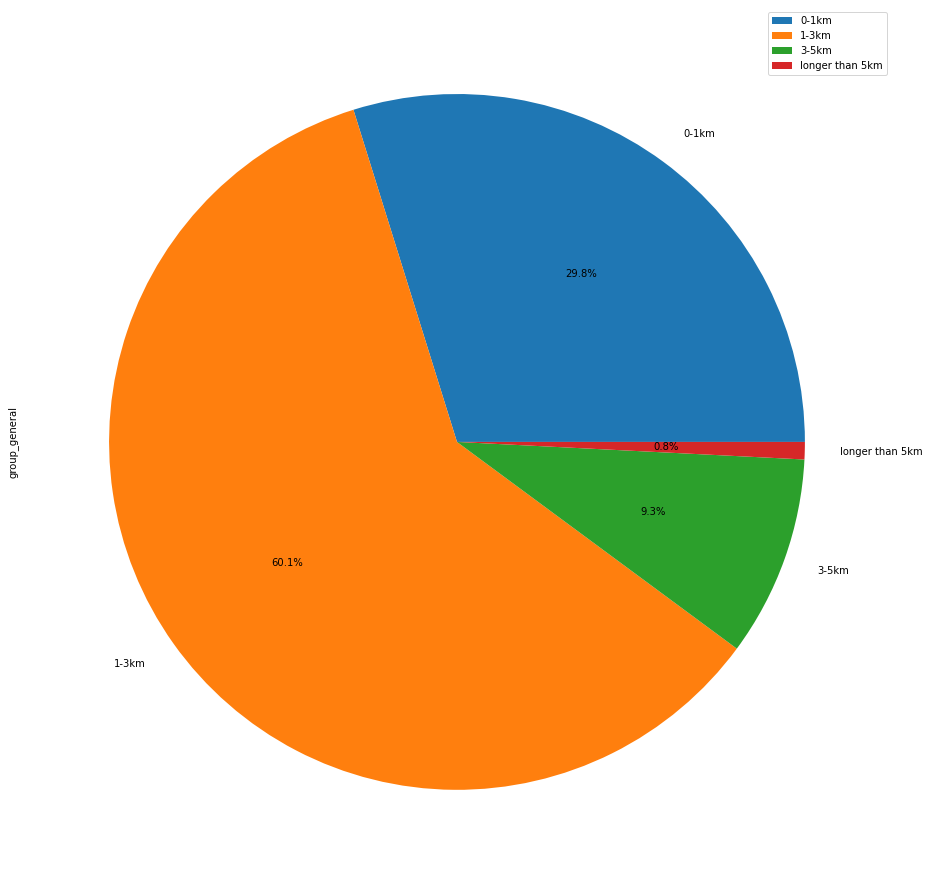

In [43]:
pie_ch=df_group_general.plot.pie(subplots=True,y='group_general', figsize=(16,16),autopct='%1.1f%%')
pie_ch